In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from pymystem3 import Mystem
from nltk.stem.snowball import SnowballStemmer
nltk.download("stopwords")
nltk.download("punkt")

SEED = 1234
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mikhail/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mikhail/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def read_data():
    with open("scores_train.txt") as f:
        y = list(map(lambda x: float(x.strip()), f.read().strip().split('\n')))
    with open("texts_train.txt") as f:
        X = list(map(lambda x: x.strip(), f.read().strip().split('\n')))
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = read_data()
print(X.shape)
print(X[0])
print(y)

(20000,)
Сериал очень люблю, но Академия и Земля вызывает у меня отторжение идеей... Не люблю, когда принижают ценность человека как личности, даже не смотря на ошибки личности...
[ 6.  7. 10. ... 10. 10.  5.]


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.85)
print(X_train.shape)

(17000,)


In [4]:
def get_regressor():
    return Pipeline([("vect", CountVectorizer(ngram_range=(1,2))),
                    ("tfidf", TfidfTransformer(sublinear_tf=True)),
                    ("sgd", SGDRegressor(loss='squared_loss', penalty='l2', alpha=1e-4, max_iter=500))
           ])

def predict_with_regressor(regressor, X):
  y_pred = regressor.predict(X)
  y_pred = np.clip(y_pred, a_max=10, a_min=1)
  y_pred = np.array(y_pred, dtype=np.int32)
  return y_pred

In [5]:
regressor = get_regressor()
regressor.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                  use_idf=True)),
                ('sgd',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss

1.8879961365862765
1.96680790453296


(array([1.000e+00, 0.000e+00, 6.000e+00, 2.700e+01, 0.000e+00, 3.220e+02,
        1.137e+03, 1.002e+03, 3.990e+02, 1.060e+02]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <a list of 10 Patch objects>)

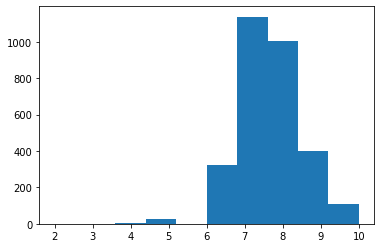

In [6]:
y_pred_train = predict_with_regressor(regressor, X_train)
y_pred_val = predict_with_regressor(regressor, X_val)
print(mean_squared_error(y_pred_train, y_train) ** 0.5)
print(mean_squared_error(y_pred_val, y_val) ** 0.5)
plt.hist(y_pred_val)

In [7]:
def read_test_data():
  with open('test.txt') as test_file:
    X = list(map(lambda x: x.strip(), test_file.read().strip().split('\n')))
  return np.array(X)

def write_output(y_pred):
  with open('out.txt', 'w') as out_file:
    for i in range(y_pred.shape[0]):
      out_file.write(str(y_pred[i]) + "\n")

def predict_test_regressor(regressor):
  X_test = read_test_data()
  y_pred = predict_with_regressor(regressor, X_test)
  write_output(y_pred)

In [8]:
predict_test_regressor(regressor)

# Let's check Stemming

In [9]:
STEMMER = SnowballStemmer("russian") 

def get_lemma_regressor(lemma_func, regression=SGDRegressor(loss='squared_loss', penalty='l2', alpha=1e-4, max_iter=500)):
  analyzer = CountVectorizer(ngram_range=(1,2)).build_analyzer()

  def stemmed_words(doc):
      return (lemma_func(w) for w in analyzer(doc))

  stem_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer=stemmed_words)
  return Pipeline([("vect", stem_vectorizer),
                ("tfidf", TfidfTransformer(sublinear_tf=True)),
                ("sgd", regression)
        ])

In [10]:
lemma_regressor = get_lemma_regressor(STEMMER.stem)
lemma_regressor.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer=<function get_lemma_regressor.<locals>.stemmed_words at 0x7f81b756b950>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                                  use_idf=True)),
                ('sgd',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=500,
 

1.8407798858731845
1.9030676989184243


(array([  4.,   0.,   9.,  57.,   0., 392., 939., 934., 491., 174.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <a list of 10 Patch objects>)

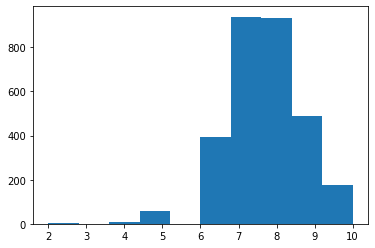

In [11]:
y_pred_train = predict_with_regressor(lemma_regressor, X_train)
y_pred_val = predict_with_regressor(lemma_regressor, X_val)
print(mean_squared_error(y_pred_train, y_train) ** 0.5)
print(mean_squared_error(y_pred_val, y_val) ** 0.5)
plt.hist(y_pred_val)

In [12]:
predict_test_regressor(lemma_regressor)

# Mystem

In [13]:
MYSTEM = Mystem()
mystem_lemma_func = lambda x: MYSTEM.lemmatize(x)[0]
mystem_lemma_func('пошел')

'пойти'

In [14]:
lemma_regressor = get_lemma_regressor(mystem_lemma_func)
lemma_regressor.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer=<function get_lemma_regressor.<locals>.stemmed_words at 0x7f80f3091620>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...
                                  use_idf=True)),
                ('sgd',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=500,
 

1.8530737580952292
1.9561867668161612


(array([  1.,   9.,  30., 143.,   0., 615., 934., 747., 362., 159.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <a list of 10 Patch objects>)

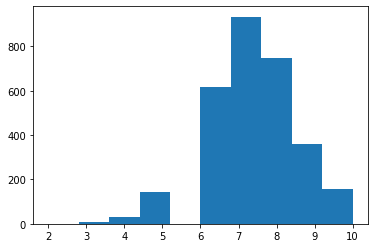

In [15]:
y_pred_train = predict_with_regressor(lemma_regressor, X_train)
y_pred_val = predict_with_regressor(lemma_regressor, X_val)
print(mean_squared_error(y_pred_train, y_train) ** 0.5)
print(mean_squared_error(y_pred_val, y_val) ** 0.5)
plt.hist(y_pred_val)

In [16]:
predict_test_regressor(lemma_regressor)

# Mystem + StopWords + Punctuation

In [17]:
STOP_WORDS = stopwords.words('russian')
STOP_WORDS.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...'])

In [18]:
def get_lemma_regressor_uni_stop(lemma_func, regression=SGDRegressor(loss='squared_loss', penalty='l2', alpha=1e-4, max_iter=500)):
  analyzer = CountVectorizer(ngram_range=(1,2)).build_analyzer()

  def stemmed_words(doc):
      return (lemma_func(w) for w in analyzer(doc) if w not in punctuation and w not in STOP_WORDS)

  stem_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer=stemmed_words, stop_words=STOP_WORDS)
  return Pipeline([("vect", stem_vectorizer),
                ("tfidf", TfidfTransformer(sublinear_tf=True)),
                ("sgd", regression)
        ])

In [19]:
lemma_regressor = get_lemma_regressor_uni_stop(mystem_lemma_func, Ridge())
lemma_regressor.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer=<function get_lemma_regressor_uni_stop.<locals>.stemmed_words at 0x7f80f305ebf8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=['и', 'в', 'во', 'н...
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...],
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2

1.8298451664917808


(array([  3.,  13.,  26.,  89., 182., 427., 732., 850., 552., 126.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

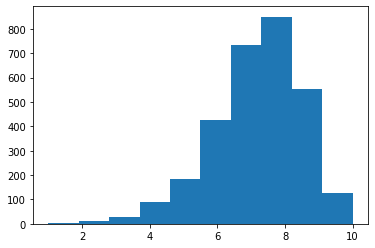

In [20]:
#y_pred_train = predict_with_regressor(lemma_regressor, X_train)
y_pred_val = predict_with_regressor(lemma_regressor, X_val)
#print(mean_squared_error(y_pred_train, y_train) ** 0.5)
print(mean_squared_error(y_pred_val, y_val) ** 0.5)
plt.hist(y_pred_val)

In [21]:
predict_test_regressor(lemma_regressor)